# Numerical Integration and Simulations
## PyIU Advanced Python Workshop

Author: Brandon Radzom

Last modified: 10/19/2024

This notebook demonstrates the power of several numerical integration/ODE solving techniques in Python.

To begin, we import the packages needed for this notebook.

In [ ]:
### general analysis packages
import numpy as np
import scipy as sp
### integration packages
from scipy.integrate import dblquad
from scipy.integrate import quad
### plotting packages
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']=100
%config InlineBackend.figure_format='svg'

### Section 1: Introduction
Real-world problems often require the use of differential equations/integrals. You are probably already familiar with what an integral is, but some of you may be less familiar with differential equations. There are generally two types: $\bf{Ordinary}$ $\bf{Differential}$ $\bf{Equations}$ (ODEs), which govern a function of just $\bf{one}$ variable, and $\bf{Partial}$ $\bf{Differential}$ $\bf{Equations}$ (PDEs), which govern a function of $\bf{multiple}$ variables. Examples of ODEs include:

* Pendulums/Simple harmonic oscillators:

$\ddot{\theta} + \frac{g}{L} \sin{\theta} = 0$ or  $\ddot{x} + \frac{k}{m} x = 0$

* 2D Ballistic motion:

$\dot x = x(0) + \ddot{x}\cdot t$

$\dot y = y(0) + \ddot{y}\cdot t$


* Exponential decay:

$\dot x = -\lambda x$

For simplicity, we will focus on ODEs only in this notebook, but PDEs are still important (ex: Schrodinger Equation!). While some of the ODEs listed above can be solved analytically, doing so requires special cases or approximations. In real life, we usually want a general solution that is applicable in all cases. This is where numerical techniques come into play- they let us solve complicated problems to extremely high accuracy!

### Section 2: Numerical ODE Solvers
#### Part 1: Euler's Method
Perhaps the easiest way to understand what it means to solve an ODE is with the simplest approach: Euler's (forward) method. By the fundamental theorem of calculus, we know any ODE (or derivative) can be expressed as the definition of a function's derivative (or slope):

$$\frac{dy}{dx}=\lim_{h \rightarrow 0} \frac{y(x+h)-y(x)}{h}$$

Numerical solutions involve a series of steps to solve equations over some range of parameter space- in this example, $x$ is our only independent variable. In this context, we can consider the $h$ written above as the step size. Re-arranging, we can approximate the unknown value of the function $y$ at a point of interest $(x+h)$ as:

$$y(x+h) \approx y(x) + \frac{dy}{dx}\Big |_x \cdot h$$

where the function's value at point $x$ (i.e., $y(x)$) is already known. You may also recognize this form of y(x) as a Taylor Series approximation, with all higher-order terms excluded. In this way, the Euler method is only accurate to $\mathcal{O} (h)$ (first-order).

As one can see, the underlying function $y(x)$ can be numerically solved by iterating the Euler method over many small time steps, which are set by the value we select for $h$. The method just uses what is known about the function's slope at a given step to guess the function's numerical value at the next step. Note that we do however need some initial condition to work from. Here's a brief example of Euler's method applied to the decay problem, where we have the following ODE: $dx/dt = -4 x$.

In [ ]:
# decay equation (first order ODE)
def decay_ODE(x):
    return -4*x
# one iteration of Euler method
def Euler_forward(y_val, dydx_val, h):
    return y_val + h*dydx_val

# define parameters
h = 0.1 # step size
times = np.arange(0, 1 + h, h) # time grid to numerically solve over
x0 = 1 # initial Condition
dx_dt0 = decay_ODE(x0) # initial condition,

# Forward Euler Method
xs = np.zeros(len(times)) # define an array to hold the function values
xs[0] = x0 # add in initial condition
dx_dts = np.zeros(len(times)) # define an array to hold the derivative values
dx_dts[0] = dx_dt0 # add in initial condition

for t in range(0, len(times)-1):
    xs[t+1] = Euler_forward(xs[t], dx_dts[t], h)
    dx_dts[t+1] = decay_ODE(xs[t+1])

Text(0.5, 0, '$t$')

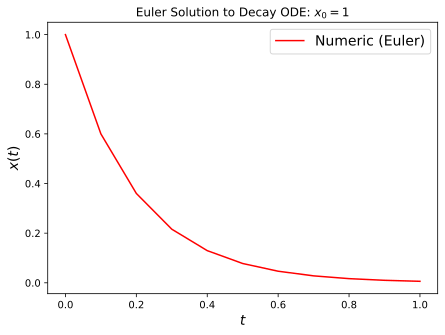

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(times, xs, 'r',label=r'Numeric (Euler)',markersize=10)
plt.legend(prop={"size":14},loc='upper right')
plt.title(fr'Euler Solution to Decay ODE: $x_0={x0}$')
plt.ylabel(r'$x(t)$',fontsize=14)
plt.xlabel(r'$t$', fontsize=14)

Great! We have a result that looks like decay, but it would be nice to verify our numerical solution's accuracy. Fortunately, we're solving an ODE that is analytically solveable by straightforward integration, with the analytic solution being: $x(t)=e^{-4t}$. Now we can plot the Euler results against this analytic result (black dashed line), as such:

Text(0.5, 0, '$t$ (sec)')

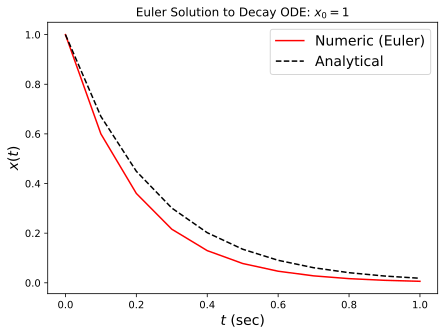

In [ ]:
def decay_soln_analytic(t):
    return np.exp(-4*t)
# define an array to hold the analytic solution
xs_analytic = np.zeros(len(times))
for t in range(len(times)):
    xs_analytic[t] = decay_soln_analytic(times[t])

plt.figure(figsize=(7,5))
plt.plot(times, xs, 'r',label=r'Numeric (Euler)',markersize=10)
plt.plot(times, xs_analytic,'k--',label=r'Analytical')
plt.legend(prop={"size":14},loc='upper right')
plt.title(fr'Euler Solution to Decay ODE: $x_0={x0}$')
plt.ylabel(r'$x(t)$',fontsize=14)
plt.xlabel(r'$t$ (sec)', fontsize=14)

This doesn't look too bad, but let's quantify our error by computing the absolute relative difference between the analytic and numeric solutions at each point, and taking the mean value of these errors:

In [ ]:
### get the absolute error at each point

# absolute error function
def abs_rel_err(true, estimated):
    return np.abs(true-estimated)/true
# error array
relative_errs = np.zeros(len(xs))
for t in range(len(xs)):
    relative_errs[t] = abs_rel_err(xs_analytic[t], xs[t])
print(f'Euler method with step size h={h}:')
print('The mean relative error is:',np.mean(relative_errs))

Euler method with step size h=0.1:
The mean relative error is: 0.3894931534683961


39\% relative error! This can certainly be improved. Let's decrease the step size $h$ by a factor of 10 to try to improve our accuracy, and re-run the Euler algorithm.

Text(0.5, 0, '$t$ (sec)')

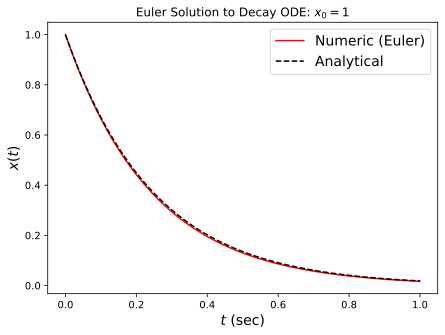

In [ ]:
# define parameters
h = 0.01 # new step size
times = np.arange(0, 1 + h, h) # time grid to numerically solve over
x0 = 1 # initial Condition
dx_dt0 = decay_ODE(x0) # initial condition,

# Forward Euler Method
xs = np.zeros(len(times)) # define an array to hold the function values
xs[0] = x0 # add in initial condition
dx_dts = np.zeros(len(times)) # define an array to hold the derivative values
dx_dts[0] = dx_dt0 # add in initial condition

for t in range(0, len(times)-1):
    xs[t+1] = Euler_forward(xs[t], dx_dts[t], h)
    dx_dts[t+1] = decay_ODE(xs[t+1])

# define an array to hold the analytic solution
xs_analytic = np.zeros(len(times))
for t in range(len(times)):
    xs_analytic[t] = decay_soln_analytic(times[t])

### make the plot
plt.figure(figsize=(7,5))
plt.plot(times, xs, 'r',label=r'Numeric (Euler)',markersize=10)
plt.plot(times, xs_analytic,'k--',label=r'Analytical')
plt.legend(prop={"size":14},loc='upper right')
plt.title(fr'Euler Solution to Decay ODE: $x_0={x0}$')
plt.ylabel(r'$x(t)$',fontsize=14)
plt.xlabel(r'$t$ (sec)', fontsize=14)

Now we see much improved agreement between the two curves! And note that because we are using a finer time grid (by decreasing the step size $h$), both curves appear much smoother. Let's compute the mean relative error again:

In [ ]:
# error array
relative_errs = np.zeros(len(xs))
for t in range(len(xs)):
    relative_errs[t] = abs_rel_err(xs_analytic[t], xs[t])
print(f'Euler method with step size h={h}:')
print('The mean relative error is:',np.mean(relative_errs))

Euler method with step size h=0.01:
The mean relative error is: 0.039990962627864904


Nice, we've decreased our relative error by a factor of $\sim10$ to just 3.9\%!

Decreasing the step size usually helps to improve any numerical solution, but there are trade-offs to be aware of. First, smaller steps sizes make ODE solving more computationally expensive, since there are more solutions to calculate. Second, setting the step sizes too small increases the number of opportunities to accumulate roundoff or truncation error on your solutions, which can be important depending on the precision needed for your solutions (i.e., how man decimal places you need). You can read more about what these types of errors are here: https://zingale.github.io/comp_astro_tutorial/basics/floating-point/numerical_error.html.

Lastly, it is important to note that the Euler method is generally *unstable*, meaning the solution can aritficially oscillate. Additionally, Euler is inaccurate for many functional forms, so it is not widely utilized in research/real life applications, though it serves as a useful introduction to numerical ODE solving.

#### Part 2: 4th-order Runge-Kutta, Adaptive Step Algorithms
In the real-world, people rely on high-order, more accurate ODE solvers. One very popular algorithm is the 4th-order Runge Kutta (RK4) method, which is a special kind of Euler-Richardson algorithm. This means that, for each time step, RK4 relies on several special midpoint/endpoint solutions to arrive at the solution value. This property makes RK4 much more accurate and stable than the simple Euler algorithm. For more details and examples for how RK4 works, see https://byjus.com/maths/runge-kutta-rk4-method/ or https://www.geeksforgeeks.org/runge-kutta-4th-order-method-solve-differential-equation/.

Let's try RK4 on our exponential decay problem. The Python package $\texttt{scipy}$ already has a built-in fuction for RK4 (which is actually a slightly higher-order implementation), along with many other ODE solving methods (see documentation here https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.RK45.html). We utilize this function here, whcih is called $\texttt{integrate.solve\_ivp}$, and once again compute the relative error with respect to the known analytic solution:

RK4 method:
The mean relative error is: 0.0009463519550296143


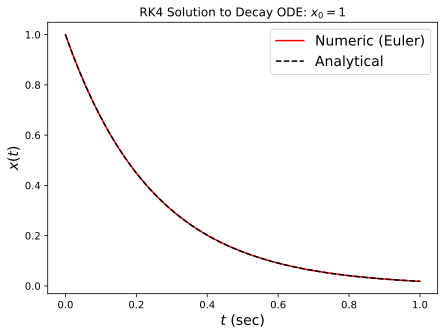

In [ ]:
# decay_xs = sp.integrate.RK45(decay_ODE, times[0], xs[0], times[-1])
def decay_ODE_rewritten(t,x):
    return -4*x
solution = sp.integrate.solve_ivp(decay_ODE_rewritten,[times[0], times[-1]], [xs[0]], t_eval=times, method='RK45')
xs = solution.y[0]

### make the plot
plt.figure(figsize=(7,5))
plt.plot(times, xs, 'r',label=r'Numeric (Euler)',markersize=10)
plt.plot(times, xs_analytic,'k--',label=r'Analytical')
plt.legend(prop={"size":14},loc='upper right')
plt.title(fr'RK4 Solution to Decay ODE: $x_0={x0}$')
plt.ylabel(r'$x(t)$',fontsize=14)
plt.xlabel(r'$t$ (sec)', fontsize=14)

# error array
relative_errs = np.zeros(len(xs))
for t in range(len(xs)):
    relative_errs[t] = abs_rel_err(xs_analytic[t], xs[t])
print(f'RK4 method:')
print('The mean relative error is:',np.mean(relative_errs))

And we see that $\texttt{scipy}$'s RK4 implementation improved the relative error by another factor of $\sim 100$ to 0.09\%!

Note that I let the solver choose its own time steps since I did not specify that argument for the $\texttt{integrate.solve\_ivp}$ function. It decides how to do this on its own by checking how much the function changes per change in time. If it changes too much (i.e., the slope is too steep), then the algorithm chooses a smaller time step and re-computes the solution. This is an example of an *adaptive step* algorithm. The allowable change per time step, or tolerance, can be set by the user (either in absolute or relative terms). Let's try this one more time, but let's set the relative error (function argument "rtol") to $10^{-6}$:

RK4 method:
The mean relative error is: 1.4288881574547154e-06


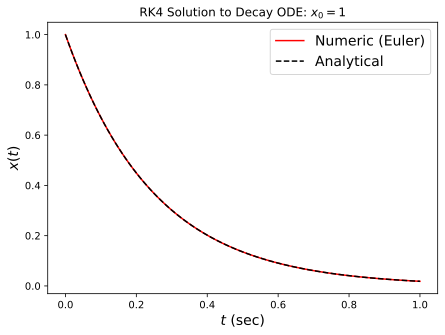

In [ ]:
# need to re-write this function to have two arguments for solve_ivp
def decay_ODE_rewritten(t,x):
    return -4*x
solution = sp.integrate.solve_ivp(decay_ODE_rewritten,[times[0], times[-1]], [xs[0]], t_eval=times, method='RK45', rtol=10**(-6)) # ,atol=1e-15,rtol=1e-13
xs = solution.y[0]

### make the plot
plt.figure(figsize=(7,5))
plt.plot(times, xs, 'r',label=r'Numeric (Euler)',markersize=10)
plt.plot(times, xs_analytic,'k--',label=r'Analytical')
plt.legend(prop={"size":14},loc='upper right')
plt.title(fr'RK4 Solution to Decay ODE: $x_0={x0}$')
plt.ylabel(r'$x(t)$',fontsize=14)
plt.xlabel(r'$t$ (sec)', fontsize=14)

# error array
relative_errs = np.zeros(len(xs))
for t in range(len(xs)):
    relative_errs[t] = abs_rel_err(xs_analytic[t], xs[t])
print(f'RK4 method:')
print('The mean relative error is:',np.mean(relative_errs))

Indeed, we find that the relative error has been further decreased to be near the relative tolerance value that we set. Neat!

### Section 3: Numerical Integration
#### Part 1: Introduction
Solving an ODE and performing an integral are one in the same; a given ODE has many potential integral curves, each of which are associated with a different set of initial conditions. Let's consider an integral of the exponential decay function discussed above, over the same time bounds as before:

$$ \int^{1}_{0} e^{-t} dt $$

Python's $\texttt{scipy}$ module contains several tools to numerically solve integrals, most of which are some form of quadrature.

#### Part 2: Integration by Quadrature (Rectangular, Trapezoid & Adaptive Step Methods)
The general idea of quadrature is to approximate the value of the integral by summing the value of the integrand (i.e., the function we want to integrate) for a series of points along the its curve. The simplest way to approach this is the rectangular method, which basically estimates the area under the curve using a series of rectangles, where the rectangles have some width $h$ (like our step size defined earlier) and some height defined by the integrand's known value at one of the edges or the middle of the rectangle. Here's a visualization of the left-side and right rectangle method, which in this specific case causes lower-bound and upper-bound estimations of the integral, respectively:
![Left-side and Right-side Reimann](./lowerupper.png)

Let's try this on our exponential decay curve from above, evaluating our integrands (1) on the left side, (2) on the right side, and (3) at the center of each rectangle:

In [ ]:
# my version of the rectangular quadrature integration scheme. Defualt behavior is to use left side of rectangle.
def rectangle_quad(integrand, var_grid, eval_at='left'):
    integral = 0
    for value in range(len(var_grid)-1):
        rectangle_width = (var_grid[value+1]-var_grid[value])
        if eval_at == 'left':
            integral += integrand(var_grid[value])*rectangle_width
        elif eval_at == 'right':
            integral += integrand(var_grid[value+1])*rectangle_width
        else: # otherwise evaluate in middle
            integral += integrand((var_grid[value] + var_grid[value+1])/2)*rectangle_width
    return integral

h = 0.1 # step size = rectangle width
times = np.arange(0, 1 + h, h) # time grid to numerically solve over
decay_curve = decay_soln_analytic(times)

decay_integral_left = rectangle_quad(decay_soln_analytic, times, eval_at='left')
decay_integral_right = rectangle_quad(decay_soln_analytic, times, eval_at='right')
decay_integral_center = rectangle_quad(decay_soln_analytic, times, eval_at='center')
print('Integral results of decay function:')
print('Using left-hand points:',decay_integral_left)
print('Using right-hand points:',decay_integral_right)
print('Using center points:',decay_integral_center)

Integral results of decay function:
Using left-hand points: 0.297768896563662
Using right-hand points: 0.19960046045253543
Using center points: 0.24379255292676671


We can see that we get slightly different answers depending on where we evaluate the integrand. Because our exponential curve is one of decay (so it is decreasing), using the left-hand points causes us to over-estimate the integral, while using the right-hand points causes us to under-estimate the integral. Using the middle of each time step provides us an answer somewhere in the middle, which we will soon see is much more accurate. To visualize this concept, let's see what our rectangles look like overplotted on our exponential curve, where the integrand evaluation points are displayed as circles:

In [ ]:
# import patches to draw rectangles
import matplotlib.patches as patches

Text(0.5, 0, '$t$ (sec)')

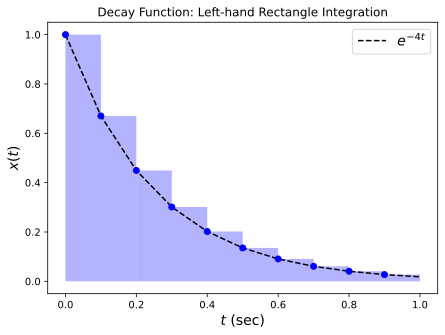

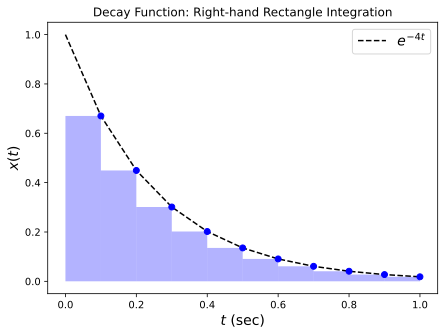

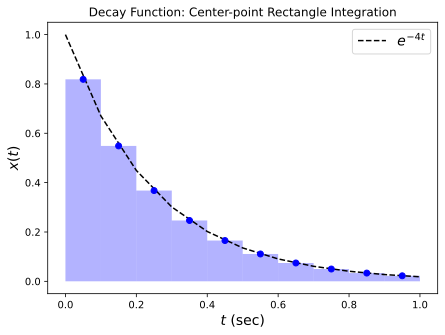

In [ ]:
### ----------------------------------------- left-hand Rectangle case ---------------------------------------

### make the plot
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
ax.plot(times, decay_curve,'k--',label=r'$e^{-4t}$')
# ax = fig.add_subplot(111, aspect='equal')
for t in range(len(times)-1):
    rectangle_width = (times[t+1]-times[t])
    rectangle_height = decay_curve[t]
    ax.add_patch(
        patches.Rectangle((times[t], 0), rectangle_width, rectangle_height, alpha=0.3, fc='blue'))
    ax.plot(times[t], decay_soln_analytic(times[t]),marker='o',color='blue')
plt.legend(prop={"size":14},loc='upper right')
plt.title(fr'Decay Function: Left-hand Rectangle Integration')
plt.ylabel(r'$x(t)$',fontsize=14)
plt.xlabel(r'$t$ (sec)', fontsize=14)

### ------------------------------------------- right-hand Rectangle case -------------------------------------

### make the plot
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
ax.plot(times, decay_curve,'k--',label=r'$e^{-4t}$')
# ax = fig.add_subplot(111, aspect='equal')
for t in range(len(times)-1):
    rectangle_width = (times[t+1]-times[t])
    rectangle_height = decay_curve[t+1]
    ax.add_patch(
        patches.Rectangle((times[t], 0), rectangle_width, rectangle_height, alpha=0.3, fc='blue'))
    ax.plot(times[t+1], decay_soln_analytic(times[t+1]),marker='o',color='blue')
plt.legend(prop={"size":14},loc='upper right')
plt.title(fr'Decay Function: Right-hand Rectangle Integration')
plt.ylabel(r'$x(t)$',fontsize=14)
plt.xlabel(r'$t$ (sec)', fontsize=14)

### -------------------------------------------- center Rectangle case --------------------------------------

### make the plot
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
ax.plot(times, decay_curve,'k--',label=r'$e^{-4t}$')

# ax = fig.add_subplot(111, aspect='equal')
for t in range(len(times)-1):
    rectangle_width = (times[t+1]-times[t])
    rectangle_height = decay_soln_analytic((times[t]+times[t+1])/2)
    ax.add_patch(
        patches.Rectangle((times[t], 0), rectangle_width, rectangle_height, alpha=0.3, fc='blue'))
    ax.plot((times[t]+times[t+1])/2, decay_soln_analytic((times[t]+times[t+1])/2),marker='o',color='blue')
plt.legend(prop={"size":14},loc='upper right')
plt.title(fr'Decay Function: Center-point Rectangle Integration')
plt.ylabel(r'$x(t)$',fontsize=14)
plt.xlabel(r'$t$ (sec)', fontsize=14)

From the three plots above, we can clearly see that the left and right rectangle methods are less appropriate than the center-point method. We can prove this quantitatively since the integral in question has an analytic solution, which can be evaluated as such:

$$\int^{1}_{0} e^{-4t} dt = -\frac{1}{4} e^{-4t} \Big |^{1}_{0} = 0.245421 $$

So let's print out the absolute errors of each of the three rectangular methods against this analytic result:

In [ ]:
analytic_decay_integral = -(1/4)*np.exp(-4)+1/4 # evaluates to 0.2545789097
print('Analytic result is:',analytic_decay_integral)
def abs_err(true, estimate):
    return np.abs(true-estimate)

print('Decay function rectangular integral errors:')
print('Using left-hand points, error is',abs_err(analytic_decay_integral, decay_integral_left))
print('Using right-hand points, error is',abs_err(analytic_decay_integral, decay_integral_right))
print('Using center points, error is',abs_err(analytic_decay_integral, decay_integral_center))

Analytic result is: 0.24542109027781644
Decay function rectangular integral errors:
Using left-hand points, error is 0.052347806285845566
Using right-hand points, error is 0.04582062982528101
Using center points, error is 0.0016285373510497303


Indeed, we have quantitatively confirmed that the center-point method performed the best.

We can do much better than this, as you might expect. We can use trapezoids rather than rectangles using $\texttt{scipy}$'s $\texttt{cumtrapz}$ function:

In [ ]:
decay_cumtrapz = sp.integrate.cumtrapz(decay_soln_analytic(times), x=times)[-1]
print('Decay function trapezoid integral:',decay_cumtrapz)
print('Decay function trapezoid integral error:',abs_err(analytic_decay_integral, decay_cumtrapz))

Decay function trapezoid integral: 0.24868467850809875
Decay function trapezoid integral error: 0.003263588230282305


Or ever better yet, we can use $\texttt{scipy}$'s $\texttt{quad}$ method (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html), which relies on some advanced adaptive step techniques. To do so, we need to define our integrand as a "lambda" function and supply $\texttt{quad}$ with any arguments the function has. You can read more about how and when to use these nifty lambda functions here: https://realpython.com/python-lambda/.

In [ ]:
# define our lambda function
decay_lambda_func = lambda t: np.exp(-4*t)
# grab the 0th element of the return object
decay_quad = sp.integrate.quad(decay_lambda_func, times[0], times[-1])[0]
print('Decay function quad integral:',decay_quad)
print('Decay function quad integral error:',abs_err(analytic_decay_integral, decay_quad))
#(func, a, b, args=(), full_output=0, epsabs=1.49e-08, epsrel=1.49e-08

Decay function quad integral: 0.24542109027781647
Decay function quad integral error: 2.7755575615628914e-17


Note we can specify either the relative or absolute error (as was seen previously with $\texttt{solve_ivp}$) to guarentee we achieve any given accuracy.

$\texttt{scipy}$ also contains the functions $\texttt{dblquad}$ (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.dblquad.html) and $\texttt{tplquad}$ (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.tplquad.html) for double and triple integrals, respectively.

#### Part 3: Astronomy Application: Numerical N-body Simulations

Perhaps the most common use of numerical integration schemes in astronomy is for numerical simulations of moving bodies under the influence of gravity, also known as N-body simulations. These are important because the equations of motion for any system containing 3 or more bodies do not have general analytic solutions, meaning they must be studied numerically. This means that we need numerical integration, even to understand the orbital evolution of the 8 planets in our own solar system!

Numerical integration has also been used in astronomy to simulate:
* Large-scale evolution of our universe over billions of years
* Galactic formation \& evolution for galaxies of various morphologies, over billions of years
* Dynamical evolution of globular clusters containing thousands to millions of stars, over millions of years (see Ethan White's work)
* Dynamical formation \& evolution of exoplanetary systems and their protoplanetary disks over millions of years (see Brandon Radzom's work!)

Want to try your own N-body simulation? Coding up your own N-body integrator can be quite challenging and unnecessary. Fortunately, many efficient N-body integration techniques exist and are publicly available. The exact integrator you use will depend on your required accuracy, the number of particles you're simulating, and the timescale you're interested in. Most modern integrators use some form of adaptive stepping, as discussed previously. The $\texttt{rebound}$ Python package, which can be installed following the instructions here https://rebound.readthedocs.io/en/latest/quickstart_installation/, is a user-friendly N-body integrator that is great to get started with. It is optimized for systems containing relatively few particles.

On the other hand, if you have many bodies to integrate ($\gtrsim 100$), you might consider using a code not in Python like $\texttt{NBODY6++}$ (https://github.com/nbodyx/Nbody6ppGPU) or $\texttt{GADGET}$ (https://wwwmpa.mpa-garching.mpg.de/gadget/).

In any case, if you think you're interested in running your own N-body simulations, or want to learn more, ask Brandon \& Ethan about their work!

Here are some gifs from Brandon's exoplanet N-body simulations:

**Hot Jupiter evolution:**
![Hot Jupiter Simulation](./sys39_ecc_vs_sma.gif)

**Warm Jupiter evolution:**
![Warm Jupiter Simulation](./sys163_ecc_vs_sma.gif)